In [2]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
df = pd.read_excel('Pralov.xls', skiprows=8)
df = df.dropna()

print(df)

     Reference Code              Date Time  \
0           0WPVCY9    2025-05-28 14:32:57   
1           0XRKVN9  2025-05-27 21:59:03.0   
2           0XRHORM  2025-05-27 20:51:19.0   
3           0XR8ZO5  2025-05-27 19:10:16.0   
4           0XQDXTQ  2025-05-27 11:20:44.0   
...             ...                    ...   
3733        8ZALG8P    2025-05-27 14:57:00   
3734        C2K2TYK    2025-05-21 21:45:00   
3735        GIW1YEQ    2025-05-13 18:40:00   
3736        BC6HQED    2025-05-31 02:27:00   
3737        1G2YAPL    2025-05-08 15:56:00   

                                  Description    Dr.      Cr.    Status  \
0       Paid for Dipesh Hair Cutting & Saloon  150.0     0.00  COMPLETE   
1            Fund Transferred by Biplov Malla    0.0   200.00  COMPLETE   
2     Fund Transferred to Bel Prasad Shrestha  400.0     0.00  COMPLETE   
3                 Paid for NANDINI FOOD COURT  370.0     0.00  COMPLETE   
4                    Paid for Shahi Suppliers   80.0     0.00  COMPLETE 

Preprocessing

In [4]:
percentage = df.groupby('Category').size() / len(df)
other_list = percentage[percentage<0.05].index.tolist()

def new_apply(x):
    if x in other_list:
        return "others"
    else:
        return x

df['Category'] = df['Category'].apply(lambda x: new_apply(x))
print(df['Category'].value_counts())

Category
Groceries & Shopping    458
Banking & Finance       427
Dining & Food           423
Income                  417
Subscriptions           410
Personal Care           402
Entertainment           400
Travel                  400
Education               400
others                    1
Name: count, dtype: int64


Feature Selection

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Category_Encoded'] = le.fit_transform(df['Category'])

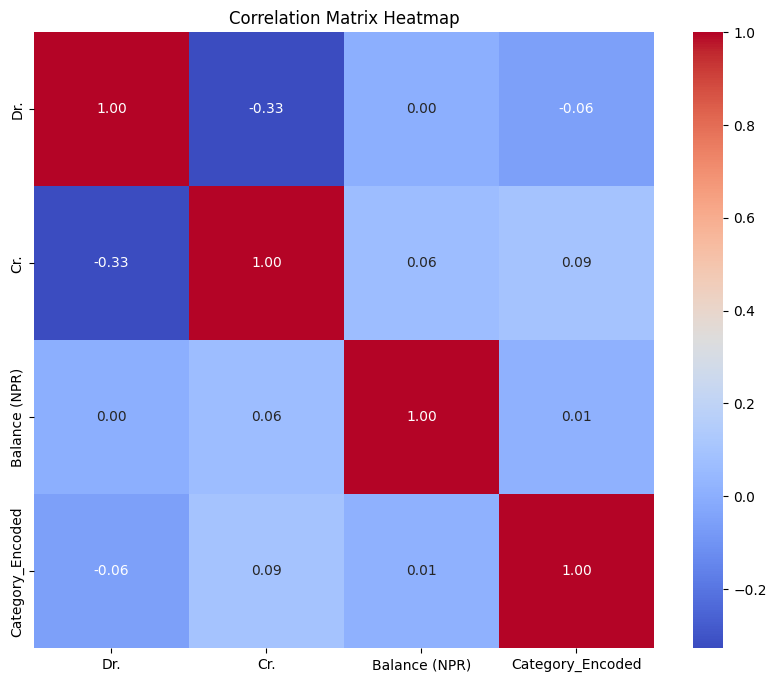

In [6]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot = True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [7]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['Category'], df['Description'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistics: {chi2}")
print(f"P-value: {p}")

Chi-square statistics: 33642.0
P-value: 0.0


## Basic Text Preprocessing

In [8]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\swoye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swoye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\swoye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\swoye\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\swoye\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [9]:
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [10]:
def textPreprocessing(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()  
    text = word_tokenize(text)
    return text

def stopwordRemoval(text):
    text = [word for word in text if word not in stop_words]
    return text

def lemmatization(text):
    text = [lemmatizer.lemmatize(word) for word in text]
    return text 

def posTagging(text):
    text = nltk.pos_tag(text)
    text = [word for word, tag in text if tag.startswith('N') or tag.startswith('V')]   
    return text

def cleanTextPipeline(text):
    text = textPreprocessing(text)
    text = stopwordRemoval(text)
    text = lemmatization(text)
    text = posTagging(text)
    text = ' '.join(text)
    return text

df['processedDescription'] = df["Description"].apply(lambda x : cleanTextPipeline(x))


In [11]:
# augmenter = TransactionDataAugmenter()
# augmented_df = augmenter.augment_dataset(df)

# print(f"Original dataset size: {len(df)}")
# print(f"Augmented dataset size: {len(augmented_df)}")
# print(augmented_df.tail(20))

# Model Initialization

In [12]:
import transformers

c:\Users\swoye\anaconda3\envs\finance_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# !pip uninstall -y transformers torch datasets
# !pip cache purge

In [14]:
# !pip install torch==2.0.1
# !pip install transformers==4.30.2 datasets==2.13.1 evaluate==0.4.0
# !pip install accelerate==0.20.3

In [15]:
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers.trainer import Trainer
from transformers.training_args import TrainingArguments
from torch.utils.data import Dataset, DataLoader
import evaluate
from transformers import DataCollatorWithPadding
from sklearn.model_selection import train_test_split

# Verify installations
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.0.1+cpu
Transformers version: 4.30.2
CUDA available: False


In [16]:
model_path = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_path)

unique_labels = df['Category'].unique()
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                           num_labels = len(unique_labels),
                                                           id2label=id_to_label,
                                                           label2id=label_to_id)

c:\Users\swoye\anaconda3\envs\finance_env\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequen

In [17]:
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

In [18]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['processedDescription'].tolist(),
    df['Category'].map(label_to_id).tolist(),
    test_size=0.2,
    random_state=42
)

class TransactionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors='pt'  
        )
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {
            key: val[idx] 
            for key, val in self.encodings.items()
        }
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TransactionDataset(train_texts, train_labels, tokenizer)
val_dataset = TransactionDataset(val_texts, val_labels, tokenizer)

In [19]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import numpy as np
import torch.nn.functional as F

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    probabilities = F.softmax(torch.tensor(predictions), dim = 1).numpy()
    
    predicted_classes = np.argmax(predictions, axis=1)
    
    acc = np.round(accuracy.compute(
        predictions=predicted_classes, 
        references=labels
    )['accuracy'], 3)
    
    labels_one_hot = label_binarize(
        labels, 
        classes=np.arange(len(unique_labels))
    )
    
    try:
        auc = np.round(roc_auc_score(
            labels_one_hot, 
            probabilities, 
            multi_class='ovr',
            average='macro'
        ), 3)

    except ValueError:
        auc = 0.0
    
    return {
        'accuracy': acc,
        'roc_auc': auc,
        'num_classes': len(unique_labels)
    }

# print(df[["Description", "processedDescription", "combined_text", "Category", "Dr.", "Cr.", "Balance (NPR)"]])
print(df.head(50))

   Reference Code              Date Time  \
0         0WPVCY9    2025-05-28 14:32:57   
1         0XRKVN9  2025-05-27 21:59:03.0   
2         0XRHORM  2025-05-27 20:51:19.0   
3         0XR8ZO5  2025-05-27 19:10:16.0   
4         0XQDXTQ  2025-05-27 11:20:44.0   
5         0XQC53Q  2025-05-27 10:52:01.0   
6         0XQ8B8O  2025-05-27 09:49:27.0   
7         0XPWHJ3  2025-05-26 21:36:03.0   
8         0XPVO19  2025-05-26 21:17:09.0   
9         0XPP0CU  2025-05-26 19:44:14.0   
10        0XPMP0F  2025-05-26 19:19:51.0   
11        0XOQOOW  2025-05-26 11:21:04.0   
12        0XMXQWA  2025-05-25 10:09:49.0   
13        0XMXQWA  2025-05-25 10:09:49.0   
14        0XM921W  2025-05-24 18:57:15.0   
15        0XM7VTE  2025-05-24 18:41:21.0   
16        0XM6S3V  2025-05-24 18:25:44.0   
17        0XKZQYA  2025-05-23 20:37:38.0   
18        0XKVNFX  2025-05-23 19:52:59.0   
19        0XKG06J  2025-05-23 16:35:16.0   
20        0XKDOUJ  2025-05-23 16:01:09.0   
21        0XJR9V0  2025-05-23 10

In [21]:
# class WeightedLossTrainer(Trainer):
#     def __init__(self, class_weights, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.class_weights = torch.tensor(list(class_weights.values()), dtype = torch.float32,
#                                           device = self.model.device)
    
#     def compute_loss(self, model, inputs, return_outputs = False):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.logits.float()

#         loss_fct = nn.CrossEntropyLoss(weight = self.class_weights)
#         loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

#         if return_outputs:
#             return (loss, outputs)
#         return loss 

In [22]:
# from sklearn.utils.class_weight import compute_class_weight

# labels = df['Category'].map(label_to_id).values
# class_weights = compute_class_weight('balanced', classes=np.unique(labels), y = labels).astype(np.float32)

# class_weight_dict = {i: float(weight) for i, weight in enumerate(class_weights)}
# print("\nClass Weights:")
# for category, idx in label_to_id.items():
#     print(f"{category}: {class_weight_dict[idx]:.2f}")

lr = 2e-2
batch_size = 16
num_epochs = 1

training_args = TrainingArguments(
    output_dir='./Transaction_Classifier',
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy='epoch',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

c:\Users\swoye\anaconda3\envs\finance_env\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 187/187 [00:48<00:00,  4.53it/s]

{'loss': 1.0833, 'learning_rate': 0.0, 'epoch': 1.0}


c:\Users\swoye\anaconda3\envs\finance_env\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
                                                 
100%|██████████| 187/187 [00:57<00:00,  4.53it/s]

{'eval_loss': 0.0628979429602623, 'eval_accuracy': 0.983, 'eval_roc_auc': nan, 'eval_num_classes': 10, 'eval_runtime': 9.476, 'eval_samples_per_second': 78.937, 'eval_steps_per_second': 4.96, 'epoch': 1.0}


100%|██████████| 187/187 [00:58<00:00,  3.19it/s]

{'train_runtime': 58.605, 'train_samples_per_second': 51.02, 'train_steps_per_second': 3.191, 'train_loss': 1.0833036045339657, 'epoch': 1.0}


TrainOutput(global_step=187, training_loss=1.0833036045339657, metrics={'train_runtime': 58.605, 'train_samples_per_second': 51.02, 'train_steps_per_second': 3.191, 'train_loss': 1.0833036045339657, 'epoch': 1.0})

In [23]:
print(f"Best model path: {trainer.state.best_model_checkpoint}")

best_model = AutoModelForSequenceClassification.from_pretrained(trainer.state.best_model_checkpoint)
print(best_model)

Best model path: ./Transaction_Classifier\checkpoint-187
DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FF

In [26]:
best_model.save_pretrained("./backend/saved_model")
tokenizer.save_pretrained("./backend/saved_model")

('./backend/saved_model\\tokenizer_config.json',
 './backend/saved_model\\special_tokens_map.json',
 './backend/saved_model\\vocab.txt',
 './backend/saved_model\\added_tokens.json',
 './backend/saved_model\\tokenizer.json')

In [25]:
def predict_transaction(text):
    inputs = tokenizer(text, truncation=True, padding=True, max_length = 128, return_tensors = 'pt')
    output = best_model(**inputs)
    print(output)
    predictions = output.logits.softmax(dim=-1)

    print(predictions)
    
    predicted_class = predictions.argmax().item()

    print(predicted_class)

    confidence = predictions[0][predicted_class].item()

    return {
        'category': id_to_label[predicted_class],
        'confidence': f"{confidence:.2%}"
    }

test_text = "purchase tomato"

final_text = cleanTextPipeline(test_text)

result = predict_transaction(final_text)

print(
    f"Category: {result['category']}\nConfidence score: {result['confidence']}"
)

print(id_to_label)

SequenceClassifierOutput(loss=None, logits=tensor([[-0.3725,  2.6164, -1.7936,  3.2971,  3.7122,  0.4849, -9.6292, -2.7077,
         -3.1252, -3.1133]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor([[8.1733e-03, 1.6236e-01, 1.9736e-03, 3.2070e-01, 4.8568e-01, 1.9265e-02,
         7.8033e-07, 7.9113e-04, 5.2112e-04, 5.2733e-04]],
       grad_fn=<SoftmaxBackward0>)
4
Category: Groceries & Shopping
Confidence score: 48.57%
{0: 'Personal Care', 1: 'Income', 2: 'Banking & Finance', 3: 'Dining & Food', 4: 'Groceries & Shopping', 5: 'Subscriptions', 6: 'others', 7: 'Entertainment', 8: 'Travel', 9: 'Education'}
